In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize, Bounds
import plotly.express as px
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
# импортируем генераторы процессов с разными рычагами и KL метрику (в данном случае будем использовать среднее значение KL)
from leverage_functions_and_metrics import gen_e, gen_gjr, gen_poly, gen_t, gen_lin 
from leverage_functions_and_metrics import l_e, l_gjr, l_poly, l_t, KL
import time

## Cгенерируем GARCH процессы с разными рычагами

In [3]:
np.random.seed(1980)
n = 1000
nu = np.random.normal(0,1, n)

In [4]:
# инициализируем параметры
x_e = np.array([0.2,0.3,0.1, -0.5, 0.9])
x_gjr = np.array([0.02,0.03,0.01, 0.05, 0.9])
x_poly = np.array([0.2,0.3,0.1, -0.5,0.15, 0.9])
x_t = np.array([0.2,0.3,0.1, -0.5, 0.9])
x_lin = np.array([0.118, 0.24, 0.119, 0.286, 0.225, 0.441, -0.024, 0.012, -0.28 ,0.023, 0.045, 0.015, 0.658, 0.9])

In [5]:
# сохраним волатильности
sigma_e = gen_e(x_e, nu)
sigma_gjr = gen_gjr(x_gjr, nu)
sigma_poly = gen_poly(x_poly, nu)
sigma_t = gen_t(x_t, nu)
sigma_lin = gen_lin(x_lin, nu)

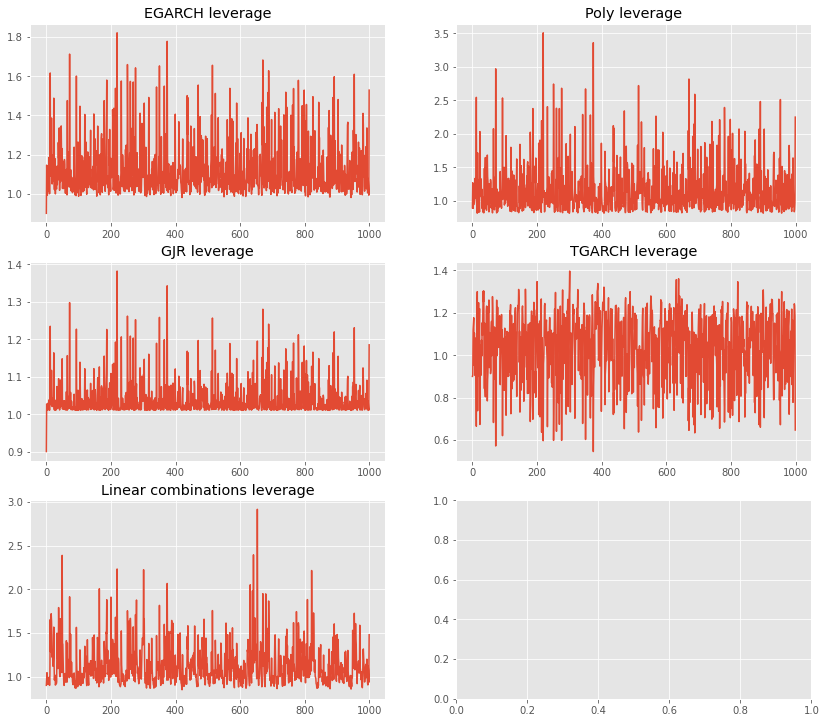

In [6]:
# отрисуем процессы
fig, ax = plt.subplots(3,2, figsize = (14,5))
plt.subplots_adjust(left=None , bottom=None, right=None, top=2, wspace=None, hspace=None)
sns.lineplot(x=range(n), y = sigma_e, ax=ax[0,0])
ax[0,0].set_title('EGARCH leverage')
sns.lineplot(x=range(n), y = sigma_gjr, ax=ax[1,0])
ax[1,0].set_title('GJR leverage')
sns.lineplot(x=range(n), y = sigma_poly, ax=ax[0,1])
ax[0,1].set_title('Poly leverage')
sns.lineplot(x=range(n), y = sigma_t, ax=ax[1,1])
ax[1,1].set_title('TGARCH leverage');
sns.lineplot(x=range(n), y = sigma_lin, ax=ax[2,0])
ax[2,0].set_title('Linear combinations leverage');

# Приблизим поочередно GARCH процессы 

In [7]:
# создадим списки с генераторами, наименованиями и начальными параметрами
gen = [gen_e, gen_gjr, gen_poly, gen_t, gen_lin]
names = ['egarch', 'gjr','poly', 'tgarch', 'lin']
x0 = [x_e, x_gjr*0.2, x_poly, x_t, x_lin]

## Приблизим процессы к EGARCH

In [8]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}
    if names[i] == 'lin':
        opts = {'maxiter' : 500, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i], args=(sigma_e, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions.py:78: RuntimeWarning: overflow encountered in exp
  eps_gjr[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions.py:77: RuntimeWarning: invalid value encountered in double_scalars
  sigmalog2[t] = w + a*eps_gjr[t-1]**2 +theta * (eps_gjr[t-1]<0)*eps_gjr[t-1]**2 + b*sigmalog2[t-1]
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions.py:79: RuntimeWarning: overflow encountered in exp
  return np.sqrt(np.exp(sigmalog2))


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  15   |   0   | +1.7219e-02 | 1.00e+00 | 5.78e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |  30   |   1   | +6.5421e-03 | 5.77e+00 | 3.11e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   3   |  45   |   3   | +9.1439e-03 | 9.59e+00 | 2.41e-02 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   4   |
|   4   |  45   |   3   | +9.1439e-03 | 4.80e+01 | 1.23e-02 | 0.00e+00 | 1.00e+00 |  2.00e-02   |   0   |
|   5   |  45   |   3   | +9.1439e-03 | 2.40e+02 | 1.31e-02 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   0   |
|   6   |  60   |   4   | +6.0670e-03 | 2.40e+02 | 8.13e-03 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   4   |
|   7   |  75   |   5   | +3.9336e-03 | 2.40e+02 | 3.03e-03 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   4   |
|   8   |  75   |   5   | +3.9336e-03 | 1.20e+

|  77   | 1050  |  332  | +8.8467e-08 | 3.75e+05 | 9.01e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  78   | 1065  |  335  | +8.3465e-08 | 3.75e+05 | 1.47e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  79   | 1080  |  347  | +4.6386e-08 | 3.75e+05 | 1.84e-05 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  80   | 1095  |  349  | +3.6770e-08 | 3.75e+05 | 4.80e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  81   | 1110  |  353  | +3.1850e-08 | 3.75e+05 | 1.01e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  82   | 1125  |  360  | +2.9468e-08 | 3.75e+05 | 1.04e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  83   | 1140  |  372  | +1.9788e-08 | 3.75e+05 | 4.72e-06 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  84   | 1155  |  373  | +1.9542e-08 | 3.75e+05 | 9.68e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  85   | 1170  |  377  | +1.9348e-08 | 3.75e+05 | 2.75e-07 | 0.00e+00 | 1.00e+00 |  2.56e-07   |   4   |
|  86   | 1185  |  390  | +1.3531e-08 | 3.75e+

In [9]:
res1

 barrier_parameter: 1.0240000000000006e-08
 barrier_tolerance: 1.0240000000000006e-08
          cg_niter: 552
      cg_stop_cond: 4
            constr: [array([ 1.99975348e-01,  2.99950745e-01, -1.38945820e-03,  3.84928801e-05,
        6.94455873e-05,  9.99917068e-02, -4.99849099e-01,  4.90074680e-03,
       -6.65187261e-02, -2.30660098e-01, -1.32266873e-02, -2.15616353e-01,
        1.76654370e-01,  8.99975444e-01])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 40.716453075408936
               fun: 9.742954498737077e-12
              grad: array([-5.47990203e-09, -7.30529428e-09, -1.11684203e-08,  6.35907054e-09,
       -1.17346644e-09,  3.47569585e-09,  1.26548111e-08, -1.49011611e-11,
       -3.91155481e-10,  6.70552254e-11,  2.01165676e-10,  3.16649675e-10,
        3.35276127e-11, -6.22123480e-08])
               jac: [<14x14 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored

In [10]:
data_e = pd.DataFrame(res).T
data_e['fun'] # сохраним результаты

egarch         0.0
gjr       0.036783
poly       0.00078
tgarch    0.000147
lin            0.0
Name: fun, dtype: object

In [48]:
data_e.x

egarch    [0.20000000030498008, 0.300000165770267, 0.099...
gjr       [0.004, 0.006, 0.002, 0.010000000000000002, 0....
poly      [0.20777698565303254, 0.20773892884984924, 0.0...
tgarch    [-0.007693307021977431, -0.013400950390709815,...
lin       [0.19997534824801388, 0.2999507453565937, -0.0...
Name: x, dtype: object

## Приблизим процессы к GJR-GARCH

In [27]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 10000}#, 'verbose' : 3} 
    res1 = minimize(KL, x0=x0[i], args=(sigma_gjr, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
data_gjr = pd.DataFrame(res).T # сохраним результаты
data_gjr.fun

egarch    0.000181
gjr            0.0
poly      0.000064
tgarch     0.00018
lin            0.0
Name: fun, dtype: object

## Приблизим процессы к GARCH c полиномиальным рычагом

In [12]:
x0 = [x_e, x_gjr*0.01, x_poly, x_t, x_lin]

In [13]:
res = {}
for i in tqdm(range(5)):
    if names[i] == 'gjr':
        bnds = Bounds(-1,1)
    else:
        bnds = Bounds(-1,1)
    opts = {'maxiter' : 10000}#, 'verbose' : 3} 
    res1 = minimize(KL, x0=x0[i], args=(sigma_poly, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
data_poly = pd.DataFrame(res).T # сохраним результаты
data_poly.fun

egarch    0.003082
gjr       0.017117
poly           0.0
tgarch    0.005224
lin            0.0
Name: fun, dtype: object

## Приблизим процессы к TGARCH

In [15]:
res = {}
for i in tqdm(range(5)):
    if names[i] == 'gjr':
        bnds = Bounds(-3,3)
    else:
        bnds = Bounds(-1,1)
    opts = {'maxiter' : 10000}#, 'verbose' : 3} 
    res1 = minimize(KL, x0=x0[i], args=(sigma_t, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
data_t = pd.DataFrame(res).T 
data_t.fun

egarch    0.001365
gjr       0.003505
poly      0.000982
tgarch         0.0
lin            0.0
Name: fun, dtype: object

## Приблизим процессы к GARCH c рычагом, составленным из линейных комбинаций выше рассмотренных

In [17]:
res = {}
for i in tqdm(range(5)):
    if names[i] == 'gjr':
        bnds = Bounds(-3,3)
    else:
        bnds = Bounds(-1,1)
    opts = {'maxiter' : 10000}#, 'verbose' : 3} 
    res1 = minimize(KL, x0=x0[i], args=(sigma_lin, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
data_lin = pd.DataFrame(res).T
data_lin.fun

egarch     0.00141
gjr       0.003933
poly      0.000588
tgarch    0.002888
lin            0.0
Name: fun, dtype: object

### Проверим, что оптимизация прошла успешно

In [33]:
print(sum(data_lin.success)==5)
print(sum(data_poly.success)==5)
print(sum(data_gjr.success)==5)
print(sum(data_t.success)==5)

True
True
True
True


## Результаты

In [34]:
results = pd.DataFrame({'egarch':data_e.fun, 'gjr':data_gjr.fun, 'poly':data_poly.fun,'tgarch':data_t.fun, 'lin':data_lin.fun}, 
                       index = names)

In [36]:
# столбцы - GARCH процесс (с соответствующим рычагом,),который мы приближали
# строки - рычаг, с помощью которого мы придлижаем
results 

,egarch,gjr,poly,tgarch,lin
egarch,0.0,0.000181,0.003082,0.001365,0.00141
gjr,0.036783,0.0,0.017117,0.003505,0.003933
poly,0.00078,0.000064,0.0,0.000982,0.000588
tgarch,0.000147,0.00018,0.005224,0.0,0.002888
lin,0.0,0.0,0.0,0.0,0.0
